# Problem Statement

Employees are the most important part of an organization. Successful employees meet deadlines, make sales, and build the brand through positive customer interactions.

Employee attrition is a major cost to an organization and predicting such attritions is the most important requirement of the Human Resources department in many organizations. In this problem, your task is to predict the attrition rate of employees of an organization. 


In [154]:
#preprocessing libraries
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#modelling and metrics libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score

import mlflow
import mlflow.sklearn

from tqdm import tqdm
import io

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#read the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_orig = train.copy()
test_orig = test.copy()
submission_orig = submission.copy()

In [3]:
train.shape, test.shape, submission.shape

((7000, 24), (3000, 23), (5, 2))

In [4]:
train.index, test.index, submission.index

(RangeIndex(start=0, stop=7000, step=1),
 RangeIndex(start=0, stop=3000, step=1),
 RangeIndex(start=0, stop=5, step=1))

In [5]:
train.columns, test.columns, submission.columns

(Index(['Employee_ID', 'Gender', 'Age', 'Education_Level',
        'Relationship_Status', 'Hometown', 'Unit', 'Decision_skill_possess',
        'Time_of_service', 'Time_since_promotion', 'growth_rate', 'Travel_Rate',
        'Post_Level', 'Pay_Scale', 'Compensation_and_Benefits',
        'Work_Life_balance', 'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6',
        'VAR7', 'Attrition_rate'],
       dtype='object'),
 Index(['Employee_ID', 'Gender', 'Age', 'Education_Level',
        'Relationship_Status', 'Hometown', 'Unit', 'Decision_skill_possess',
        'Time_of_service', 'Time_since_promotion', 'growth_rate', 'Travel_Rate',
        'Post_Level', 'Pay_Scale', 'Compensation_and_Benefits',
        'Work_Life_balance', 'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6',
        'VAR7'],
       dtype='object'),
 Index(['Employee_ID', 'Attrition_rate'], dtype='object'))

In [6]:
train.columns.difference(test.columns), train.columns.intersection(submission.columns)

(Index(['Attrition_rate'], dtype='object'),
 Index(['Employee_ID', 'Attrition_rate'], dtype='object'))

In [7]:
tgt_var = train.columns.difference(test.columns).values[0]
tgt_var

'Attrition_rate'

In [9]:
display(train.head(2), test.head(2), submission.head(2))

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670


,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,EID_22713,F,32.0,5,Single,Springfield,R&D,Conceptual,7.0,4,...,4.0,type2,1.0,3,-0.9612,-0.4537,2.0,1,8,4
1,EID_9658,M,65.0,2,Single,Lebanon,IT,Directive,41.0,2,...,1.0,type2,1.0,4,-0.9612,0.7075,1.0,2,8,2


,Employee_ID,Attrition_rate
0,TID_1,0.1588
1,TID_2,0.1424


###### Defining functions

In [10]:
def combinfo(data) :
    combi = pd.DataFrame(data.nunique(),columns=['Nunique()'])
    combi2 = pd.DataFrame(data.isna().sum(),columns=['isna() count'])
    combi3 = pd.concat([combi, combi2],axis=1)

    #import io
    buffer = io.StringIO()
    data.info(buf=buffer, memory_usage=False)
    s = buffer.getvalue()
    df = pd.DataFrame(s.split("\n"),columns=['info'])
    df_info = df.loc[5:len(data.columns)+5-1,'info'].str.split(n=4,expand=True).reset_index(drop=True)
    df_info.drop(columns=[0,3],axis=1,inplace=True)
    df_info.columns = ['Column','Non-Null count','Dtype']
    df_info.set_index('Column',inplace=True)

    combi5 = pd.concat([combi3, df_info],axis=1)
    return combi5

In [181]:
def print_score(model,y_act,y_pred,label,genre,display,logging,model_num,n_alpha,l1_ratio, n_knn) :  
    experiment_id = mlflow.set_experiment("he_EmpAttrPred_training_exp") if logging == True else ""
    mlflow.start_run(experiment_id=experiment_id) if logging == True else ""
    
    if genre == "classification" :
        print(type(y_act), type(y_pred))
        print(y_act.head(),y_pred)
        acc_scr =  accuracy_score(y_act,y_pred)
        rec_scr =  recall_score(y_act,y_pred)
        pre_scr =  precision_score(y_act,y_pred)
        f1_scr  =  f1_score(y_act,y_pred)
        rcac_scr = roc_auc_score(y_act,y_pred)
        conf_mat = confusion_matrix(y_act,y_pred)
        
        if display == True :
            print("Model :",model)
            print(label, "Accuracy  score :", acc_scr)
            print(label, "Recall    score :", rec_scr)
            print(label, "Precision score :", pre_scr)
            print(label, "F1        score :", f1_scr)
            print(label, "ROC_AUC   score :", rcac_scr)
            print(label, "Confusion Matrix:\n", conf_mat)
            print(label, "Classification Report\n", classification_report(y_act,y_pred)) 
            res.append((model,acc_scr,rec_scr,pre_scr,f1_scr,rcac_scr,conf_mat))
 
        if logging == True :
            mlflow.log_metric("Accuracy", acc_scr)
            mlflow.log_metric("Recall", rec_scr)
            mlflow.log_metric("Precision", pre_scr)
            mlflow.log_metric("F1", f1_scr)
            mlflow.log_metric("ROC_AUC", rcac_scr)
            mlflow.log_metric("Conf.Mat", conf_mat)
        
    elif genre == "regression" :
        mse_scr  = mean_squared_error(y_act, y_pred)
        rmse_scr = mean_squared_error(y_act, y_pred,squared=False)
        mae_scr  = mean_absolute_error(y_act,y_pred)
        rmsle_scr= np.log(np.sqrt(mean_squared_error(y_act,y_pred)))
        
        print(model,type(model))
        print(str(model).split('(')[0])
        if ("Lasso" not in str(model).split('(')[0] and "ElasticNet" not in str(model).split('(')[0]) : 
            mape_scr = np.mean(np.abs((np.array(y_act) - np.array(y_pred)) / np.array(y_act))) * 100
            r2_scr   = r2_score(y_act,y_pred)
            #print("y_pred",y_pred,np.log10(y_pred +1))
            #print("y_act",y_act,np.log10(y_act +1))
            print("mean",(np.log10(y_pred +1) - np.log10(y_act +1)).mean())
            other_scr= 0#round(np.sqrt(np.mean(np.square(np.log10(y_pred +1) - np.log10(y_act +1)))),3)
            print("os2:",other_scr)
        
        if display == True :     
            print("Model :",model)
            print(label, "MSE  score :", mse_scr)
            print(label, "RMSE score :", rmse_scr)
            print(label, "MAE  score :", mae_scr)
            print(label, "RMSLE score :", rmsle_scr)
            print(str(model).split('(')[0])
            if ("Lasso" not in str(model).split('(')[0] and "ElasticNet" not in str(model).split('(')[0]) : 
                print(label, "MAPE score :", mape_scr)
                print(label, "R2   score :", r2_scr)
                print(label, "Other score:", other_scr)

        if logging == True :
            mlflow.log_metric("RMSE", rmse_scr)     
            mlflow.log_metric("RMSLE", rmsle_scr)     
            if ("Lasso" not in str(model).split('(')[0] and "ElasticNet" not in str(model).split('(')[0]) : 
                mlflow.log_metric("R2", r2_scr)
                print("os3:",other_scr)
                mlflow.log_metric("Other", other_scr)

    if logging == True :
        mlflow.log_metric("model_no",model_num) 
        mlflow.log_metric("alpha",n_alpha) 
        mlflow.log_metric("l1_ratio",l1_ratio)
        mlflow.log_metric("n_knn",n_knn)
        mlflow.sklearn.log_model(model, "Model")      
    mlflow.end_run() if logging == True else ""
    print('print_score ovr')

In [239]:
def build_model(model,X,y,label,genre,display,logging,model_num,n_alpha,l1_ratio, n_knn):
    model.fit(X,y)
    y_train_pred = model.predict(X)
    #pd.Series(data=model.coef_[0],index=X.columns).plot(kind='bar')  
    print('buildmodel-y',y)
    print('bm-ytp',y_train_pred)
    print_score(model,y,y_train_pred,label,genre,display,logging,model_num,n_alpha,l1_ratio, n_knn)
    print(type(X),type(y),type(y_train_pred))
    print(X.head(),y.head())
    xyy_pred = pd.concat([X,y], axis=1)
    xyy_pred['y_pred'] = y_train_pred
    print(type(xyy_pred),xyy_pred.head())
    print(xyy_pred[xyy_pred.Attrition_rate!=xyy_pred.y_pred].head())
    #xyy_pred[xyy_pred.Attrition_rate!=xyy_pred.y_pred].to_csv('nomatch.csv',index=False)
    print('build_model ovr')
    return y_train_pred

In [13]:
def univar_plot() :
    %matplotlib inline
    plt.figure(figsize=(16,30))
    k=1
    col_cnt = 3
    row_cnt = int(np.ceil(len(data.columns)/3))
    for col in data.columns:
        plt.subplot(row_cnt,col_cnt,k)
        if data[col].nunique()<25: 
            title='bar'
            data[col].value_counts().plot(kind ='bar')
        else: 
            title='hist'
            data[col].value_counts().plot(kind ='hist')
        #plt.title(title+'_'+col)
        plt.ylabel(title+'_'+col)    
        k+=1
    plt.show()

In [43]:
def bivar_plot_reg_all_dim() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['Employee_ID','Attrition_rate','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]

    plot_kind = 'bar' if data[tgt_var].nunique()<5 else 'hist'

    for idx, col in enumerate(data.drop(columns=['Employee_ID','Attrition_rate','source']).columns) : 
        if data[col].nunique()<25 and data[tgt_var].nunique() <5:
            cross = pd.crosstab(data[tgt_var],data[col])      
            #display(cross)
            #display(cross.div(cross.sum(1), axis=0))
            cross.div(cross.sum(1), axis=0).plot(kind=plot_kind, stacked=True, ax=ax[k])
            #plt.title(col)  
        else :
            plt.subplot(row_cnt,col_cnt,k+1)
            if data[tgt_var].nunique() < 5 :
                plt.scatter(x=data[col], y=data[tgt_var].notnull())
            else :
                plt.scatter(y=data[col].notnull(), x=data[tgt_var]) 
            plt.xlabel(col) 
        k+=1        
    plt.show() 

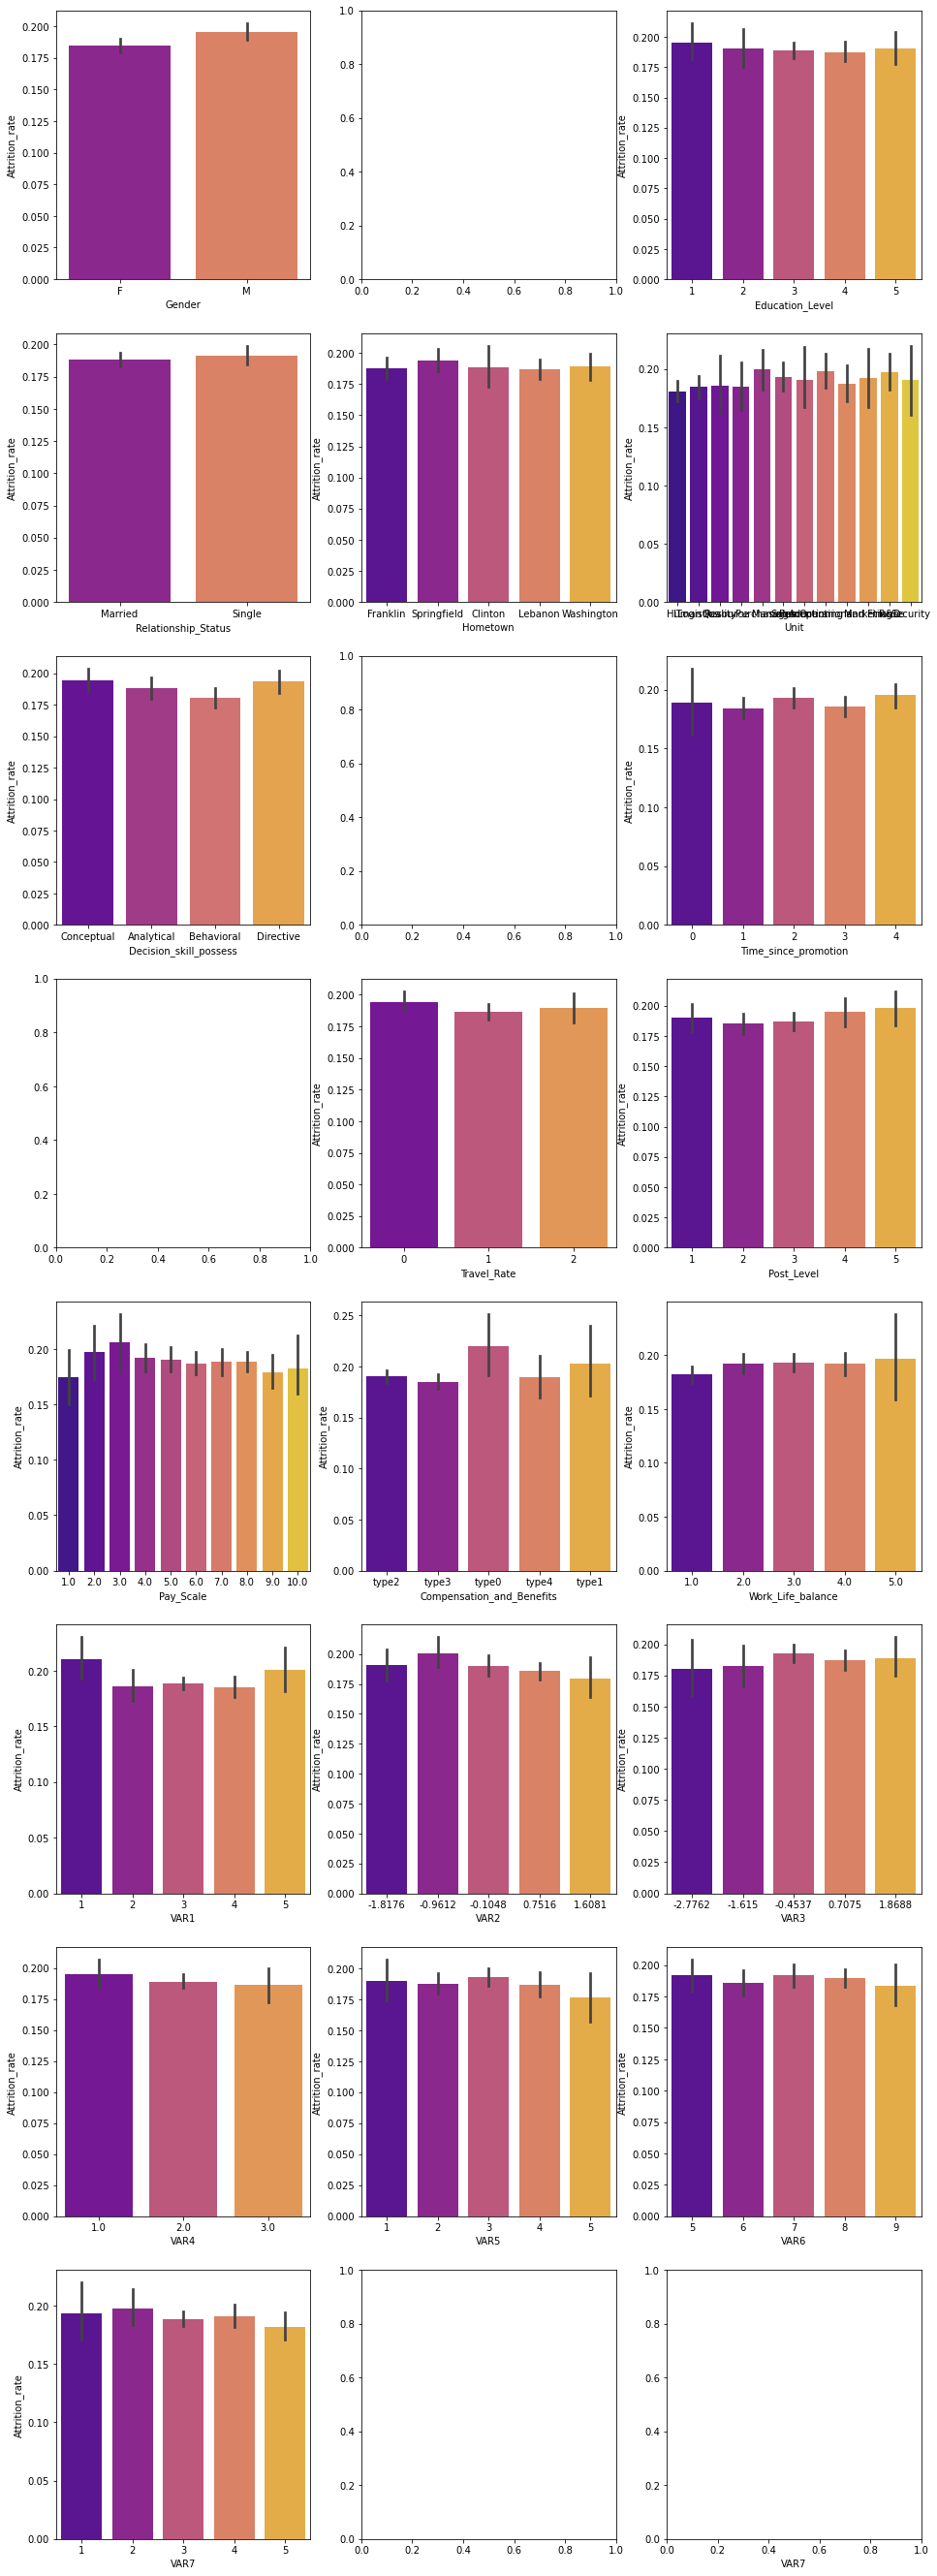

In [262]:
def bivar_plot_reg_all_dim_snsbar() :
    %matplotlib inline
    j=k=0
    col_cnt = 3
    j=[idx for idx, col in enumerate(data.drop(columns=['Employee_ID','Attrition_rate','source']).columns) if(data[col].nunique()<25) ]
    j=len(j)
    row_cnt = int(np.ceil(j/3))
    row_cnt+=1 if row_cnt%3!=0 else row_cnt

    fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
    ax = ax.flatten()
    tgt_var = train.columns.difference(test.columns).values[0]
    tgt_var
    for idx, col in enumerate(data.drop(columns=['Employee_ID','Attrition_rate','source']).columns) : 
        if(data[col].nunique()<25) :
            sns_plot = sns.barplot(x = data[col], y =data[tgt_var], data = data, palette ='plasma',ax=ax[k])
            plt.xlabel(col) 
        k+=1
    sns_plot.figure.savefig("bivar_output.png")
    #plt.show()
bivar_plot_reg_all_dim_snsbar()

In [16]:
def null_percent(data) :
    print("for all features")
    [print(data[i].isna().sum(),"(",round((data[i].isnull().sum()/len(data[i]))*100,2),"%)-->",i) \
     for i in data.columns if data[i].isna().sum()>0]

In [17]:
def range_calc(data,grouped_col,groupby_col):
    #display(type(groupby_col))
    #display(data[groupby_col].dtypes[0])
    range_calc = pd.DataFrame(data[grouped_col].value_counts().sort_index())
    range_calc = pd.concat([range_calc,
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].min()),
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].max()),
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].sum()),
                            pd.DataFrame(data.groupby(grouped_col)[groupby_col].count())
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].mean()) if data[groupby_col].dtypes[0]!='O' else "",
                            #pd.DataFrame(data.groupby(grouped_col)[groupby_col].median()) if data[groupby_col].dtypes[0]!='O' else ""                        
                           ],axis=1, ignore_index=False)
    #print(grouped_col,range_calc.index.names)
    #range_calc.index.names = [grouped_col]
    range_calc.columns=['value_count','min','max','count']#'sum','count','mean','median']
    return range_calc

In [18]:
def binning(data, bins, labels):
    bin_data = pd.cut(data2["Loan_Amount_Term"], bins=bins, labels=labels)
    return bin_data
    # example to call binning
    #bins = [0,120,180,240,300,360,480]
    #labels = ['0-120','120-180','180-240','240-300','300-360','360-480']
    ##data2["Loan_Amount_Term_bin"] = pd.cut(data2["Loan_Amount_Term"], bins=bins, labels=labels)
    #data2["Loan_Amount_Term_bin"] = binning(data2["Loan_Amount_Term"],bins,labels)

In [19]:
def vc(data, max_count,sort_idx) :
    [print(data[i].value_counts().sort_index()) for i in data.columns if data[i].nunique() < max_count]

In [20]:
def vif_inprogess() :
    #Check for Multi Collinearity
    from statsmodels.stats.outliers_influence import variance_inflation_factor 

    # the independent variables set 
    X = df.select_dtypes(include=np.number).drop(columns=["Item_Outlet_Sales"])
    X['Item_Weight'].fillna(0,inplace=True)

    # VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 

    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                              for i in range(len(X.columns))] 

    print(vif_data)

### EDA 

In [21]:
display(combinfo(train), combinfo(test), combinfo(submission))

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Employee_ID,7000,0,7000,object
Gender,2,0,7000,object
Age,47,412,6588,float64
Education_Level,5,0,7000,int64
Relationship_Status,2,0,7000,object
Hometown,5,0,7000,object
Unit,12,0,7000,object
Decision_skill_possess,4,0,7000,object
Time_of_service,44,144,6856,float64


,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Employee_ID,3000,0,3000,object
Gender,2,0,3000,object
Age,47,161,2839,float64
Education_Level,5,0,3000,int64
Relationship_Status,2,0,3000,object
Hometown,5,0,3000,object
Unit,12,0,3000,object
Decision_skill_possess,4,0,3000,object
Time_of_service,44,52,2948,float64


,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Employee_ID,5,0,5,object
Attrition_rate,5,0,5,float64


In [22]:
display(train.head(), test.head(), submission.head())

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827


,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,EID_22713,F,32.0,5,Single,Springfield,R&D,Conceptual,7.0,4,...,4.0,type2,1.0,3,-0.9612,-0.4537,2.0,1,8,4
1,EID_9658,M,65.0,2,Single,Lebanon,IT,Directive,41.0,2,...,1.0,type2,1.0,4,-0.9612,0.7075,1.0,2,8,2
2,EID_22203,M,52.0,3,Married,Springfield,Sales,Directive,21.0,3,...,8.0,type3,1.0,4,-0.1048,0.7075,2.0,1,9,3
3,EID_7652,M,50.0,5,Single,Washington,Marketing,Analytical,11.0,4,...,2.0,type0,4.0,3,-0.1048,0.7075,2.0,2,8,3
4,EID_6516,F,44.0,3,Married,Franklin,R&D,Conceptual,12.0,4,...,2.0,type2,4.0,4,1.6081,0.7075,2.0,2,7,4


,Employee_ID,Attrition_rate
0,TID_1,0.1588
1,TID_2,0.1424
2,TID_3,0.4758
3,TID_4,0.0846
4,TID_5,0.2388


In [23]:
train.duplicated().sum(), test.duplicated().sum(), submission.duplicated().sum()
# No duplicate rows

(0, 0, 0)

In [24]:
null_percent(train), null_percent(test), null_percent(submission)

for all features
412 ( 5.89 %)--> Age
144 ( 2.06 %)--> Time_of_service
9 ( 0.13 %)--> Pay_Scale
11 ( 0.16 %)--> Work_Life_balance
577 ( 8.24 %)--> VAR2
656 ( 9.37 %)--> VAR4
for all features
161 ( 5.37 %)--> Age
52 ( 1.73 %)--> Time_of_service
3 ( 0.1 %)--> Pay_Scale
5 ( 0.17 %)--> Work_Life_balance
217 ( 7.23 %)--> VAR2
298 ( 9.93 %)--> VAR4
for all features


(None, None, None)

In [25]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6588.0,39.622799,13.606920,19.0000,27.0000,37.00000,52.0000,65.0000
Education_Level,7000.0,3.187857,1.065102,1.0000,3.0000,3.00000,4.0000,5.0000
Time_of_service,6856.0,13.385064,10.364188,0.0000,5.0000,10.00000,21.0000,43.0000
Time_since_promotion,7000.0,2.367143,1.149395,0.0000,1.0000,2.00000,3.0000,4.0000
growth_rate,7000.0,47.064286,15.761406,20.0000,33.0000,47.00000,61.0000,74.0000
Travel_Rate,7000.0,0.817857,0.648205,0.0000,0.0000,1.00000,1.0000,2.0000
Post_Level,7000.0,2.798000,1.163721,1.0000,2.0000,3.00000,3.0000,5.0000
Pay_Scale,6991.0,6.006294,2.058435,1.0000,5.0000,6.00000,8.0000,10.0000
Work_Life_balance,6989.0,2.387895,1.122786,1.0000,1.0000,2.00000,3.0000,5.0000
VAR1,7000.0,3.098571,0.836377,1.0000,3.0000,3.00000,3.0000,5.0000


In [26]:
range_calc(train,"Gender","Attrition_rate")

,value_count,min,max,count
Gender,,,,
F,4114,0.0,0.9959,4114
M,2886,0.0,0.9897,2886


In [27]:
vc(train,25,True)

F    4114
M    2886
Name: Gender, dtype: int64
1     695
2     691
3    2878
4    2076
5     660
Name: Education_Level, dtype: int64
Married    4520
Single     2480
Name: Relationship_Status, dtype: int64
Clinton         565
Franklin       1523
Lebanon        2070
Springfield    1736
Washington     1106
Name: Hometown, dtype: int64
Accounting and Finance        496
Human Resource Management     344
IT                           1394
Logistics                    1173
Marketing                     212
Operarions                    706
Production                    211
Purchasing                    504
Quality                       193
R&D                           680
Sales                         943
Security                      144
Name: Unit, dtype: int64
Analytical    1755
Behavioral    1736
Conceptual    1756
Directive     1753
Name: Decision_skill_possess, dtype: int64
0     162
1    1819
2    1811
3    1703
4    1505
Name: Time_since_promotion, dtype: int64
0    2224
1    3827
2  

In [28]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train,test])
data_orig = data.copy()
display(data.head(2))
data = data.reset_index().drop(columns="index")
print(train.shape[0]+test.shape[0], data.shape, data.index)

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,source
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841,train
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670,train


10000 (10000, 25) RangeIndex(start=0, stop=10000, step=1)


In [29]:
data.duplicated().sum()

0

In [31]:
train[["Employee_ID"]].duplicated().sum(), test[["Employee_ID"]].duplicated().sum(), \
data[["Employee_ID"]].duplicated().sum()

(0, 0, 0)

In [32]:
combinfo(data)

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Employee_ID,10000,0,10000,object
Gender,2,0,10000,object
Age,47,573,9427,float64
Education_Level,5,0,10000,int64
Relationship_Status,2,0,10000,object
Hometown,5,0,10000,object
Unit,12,0,10000,object
Decision_skill_possess,4,0,10000,object
Time_of_service,44,196,9804,float64


In [33]:
null_percent(data)

for all features
573 ( 5.73 %)--> Age
196 ( 1.96 %)--> Time_of_service
12 ( 0.12 %)--> Pay_Scale
16 ( 0.16 %)--> Work_Life_balance
794 ( 7.94 %)--> VAR2
954 ( 9.54 %)--> VAR4
3000 ( 30.0 %)--> Attrition_rate


In [34]:
vc(data,25,True)

F    5842
M    4158
Name: Gender, dtype: int64
1     979
2     982
3    4063
4    3018
5     958
Name: Education_Level, dtype: int64
Married    6461
Single     3539
Name: Relationship_Status, dtype: int64
Clinton         812
Franklin       2181
Lebanon        2953
Springfield    2484
Washington     1570
Name: Hometown, dtype: int64
Accounting and Finance        679
Human Resource Management     513
IT                           1963
Logistics                    1648
Marketing                     319
Operarions                   1008
Production                    292
Purchasing                    714
Quality                       290
R&D                           991
Sales                        1389
Security                      194
Name: Unit, dtype: int64
Analytical    2501
Behavioral    2535
Conceptual    2476
Directive     2488
Name: Decision_skill_possess, dtype: int64
0     224
1    2574
2    2581
3    2434
4    2187
Name: Time_since_promotion, dtype: int64
0    3147
1    5499
2  

In [35]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,9427.0,39.675507,13.574856,19.0000,27.0000,38.00000,52.0000,65.0000
Education_Level,10000.0,3.199400,1.065436,1.0000,3.0000,3.00000,4.0000,5.0000
Time_of_service,9804.0,13.390657,10.311381,0.0000,5.0000,10.00000,21.0000,43.0000
Time_since_promotion,10000.0,2.378600,1.149780,0.0000,1.0000,2.00000,3.0000,4.0000
growth_rate,10000.0,47.008400,15.848553,20.0000,33.0000,47.00000,61.0000,74.0000
Travel_Rate,10000.0,0.820700,0.646524,0.0000,0.0000,1.00000,1.0000,2.0000
Post_Level,10000.0,2.797000,1.171037,1.0000,2.0000,3.00000,4.0000,5.0000
Pay_Scale,9988.0,6.022627,2.070087,1.0000,5.0000,6.00000,8.0000,10.0000
Work_Life_balance,9984.0,2.385817,1.128782,1.0000,1.0000,2.00000,3.0000,5.0000
VAR1,10000.0,3.089100,0.831884,1.0000,3.0000,3.00000,3.0000,5.0000


In [36]:
data.describe(exclude=np.number).T

,count,unique,top,freq
Employee_ID,10000,10000,EID_2446,1
Gender,10000,2,F,5842
Relationship_Status,10000,2,Married,6461
Hometown,10000,5,Lebanon,2953
Unit,10000,12,IT,1963
Decision_skill_possess,10000,4,Behavioral,2535
Compensation_and_Benefits,10000,5,type2,5686
source,10000,2,train,7000


<AxesSubplot:>

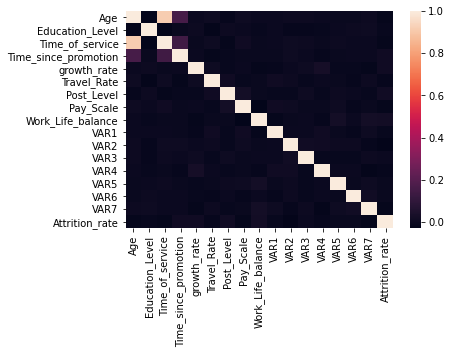

In [37]:
sns.heatmap(data.corr())

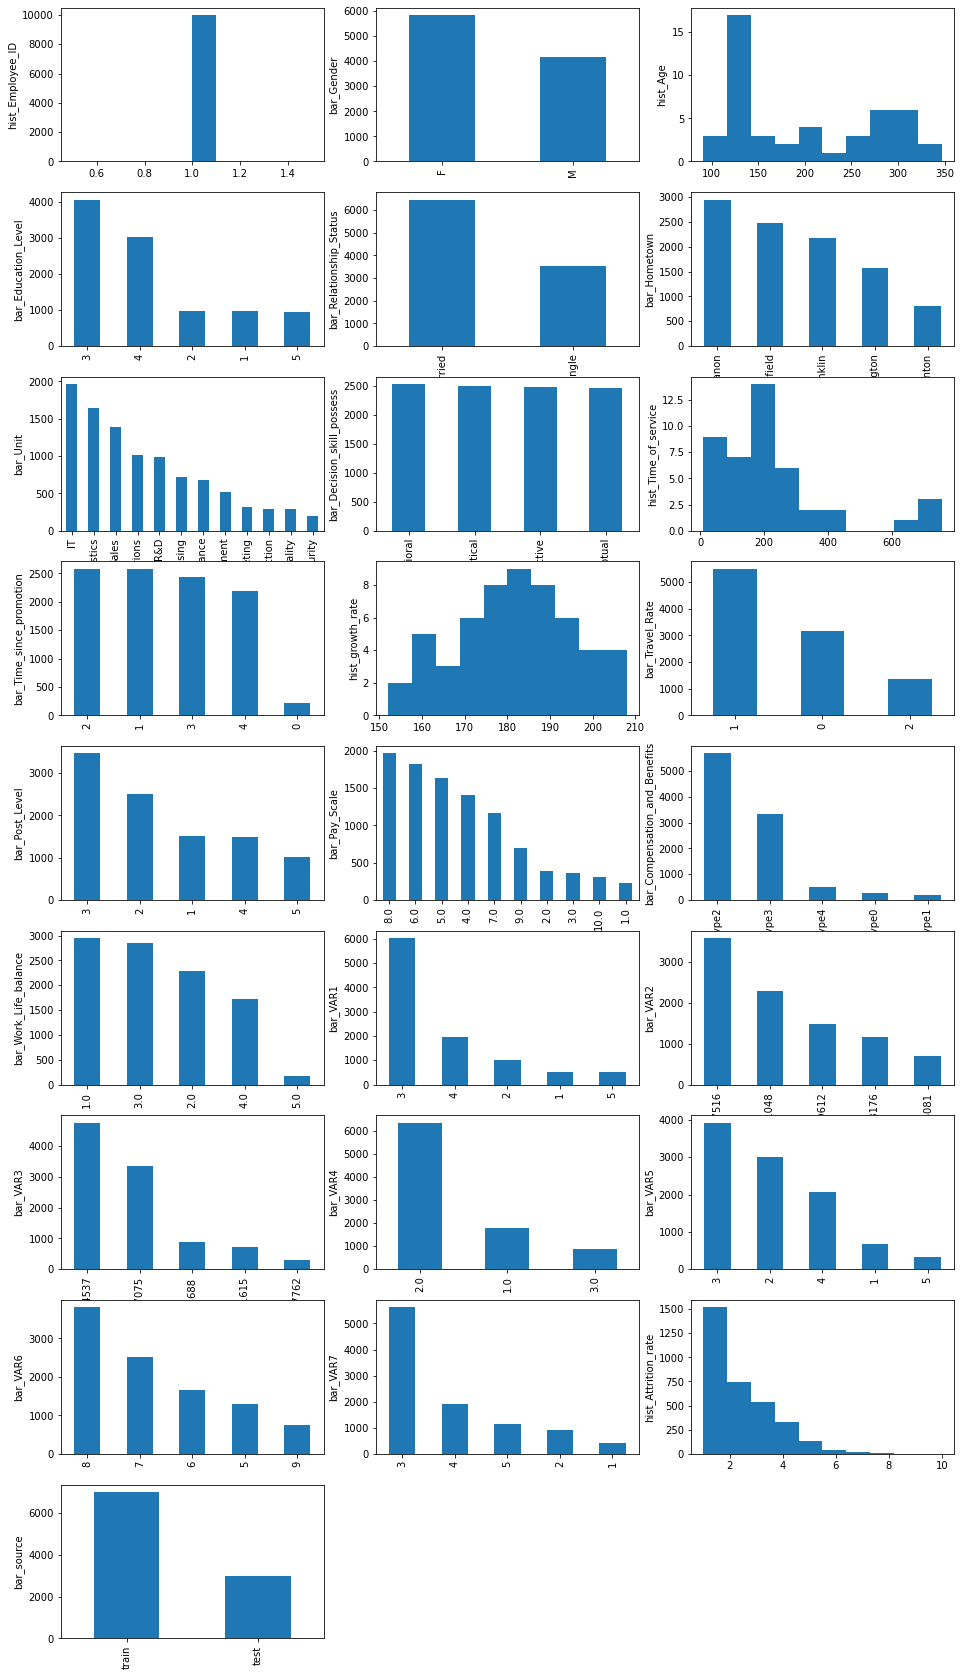

In [38]:
univar_plot()

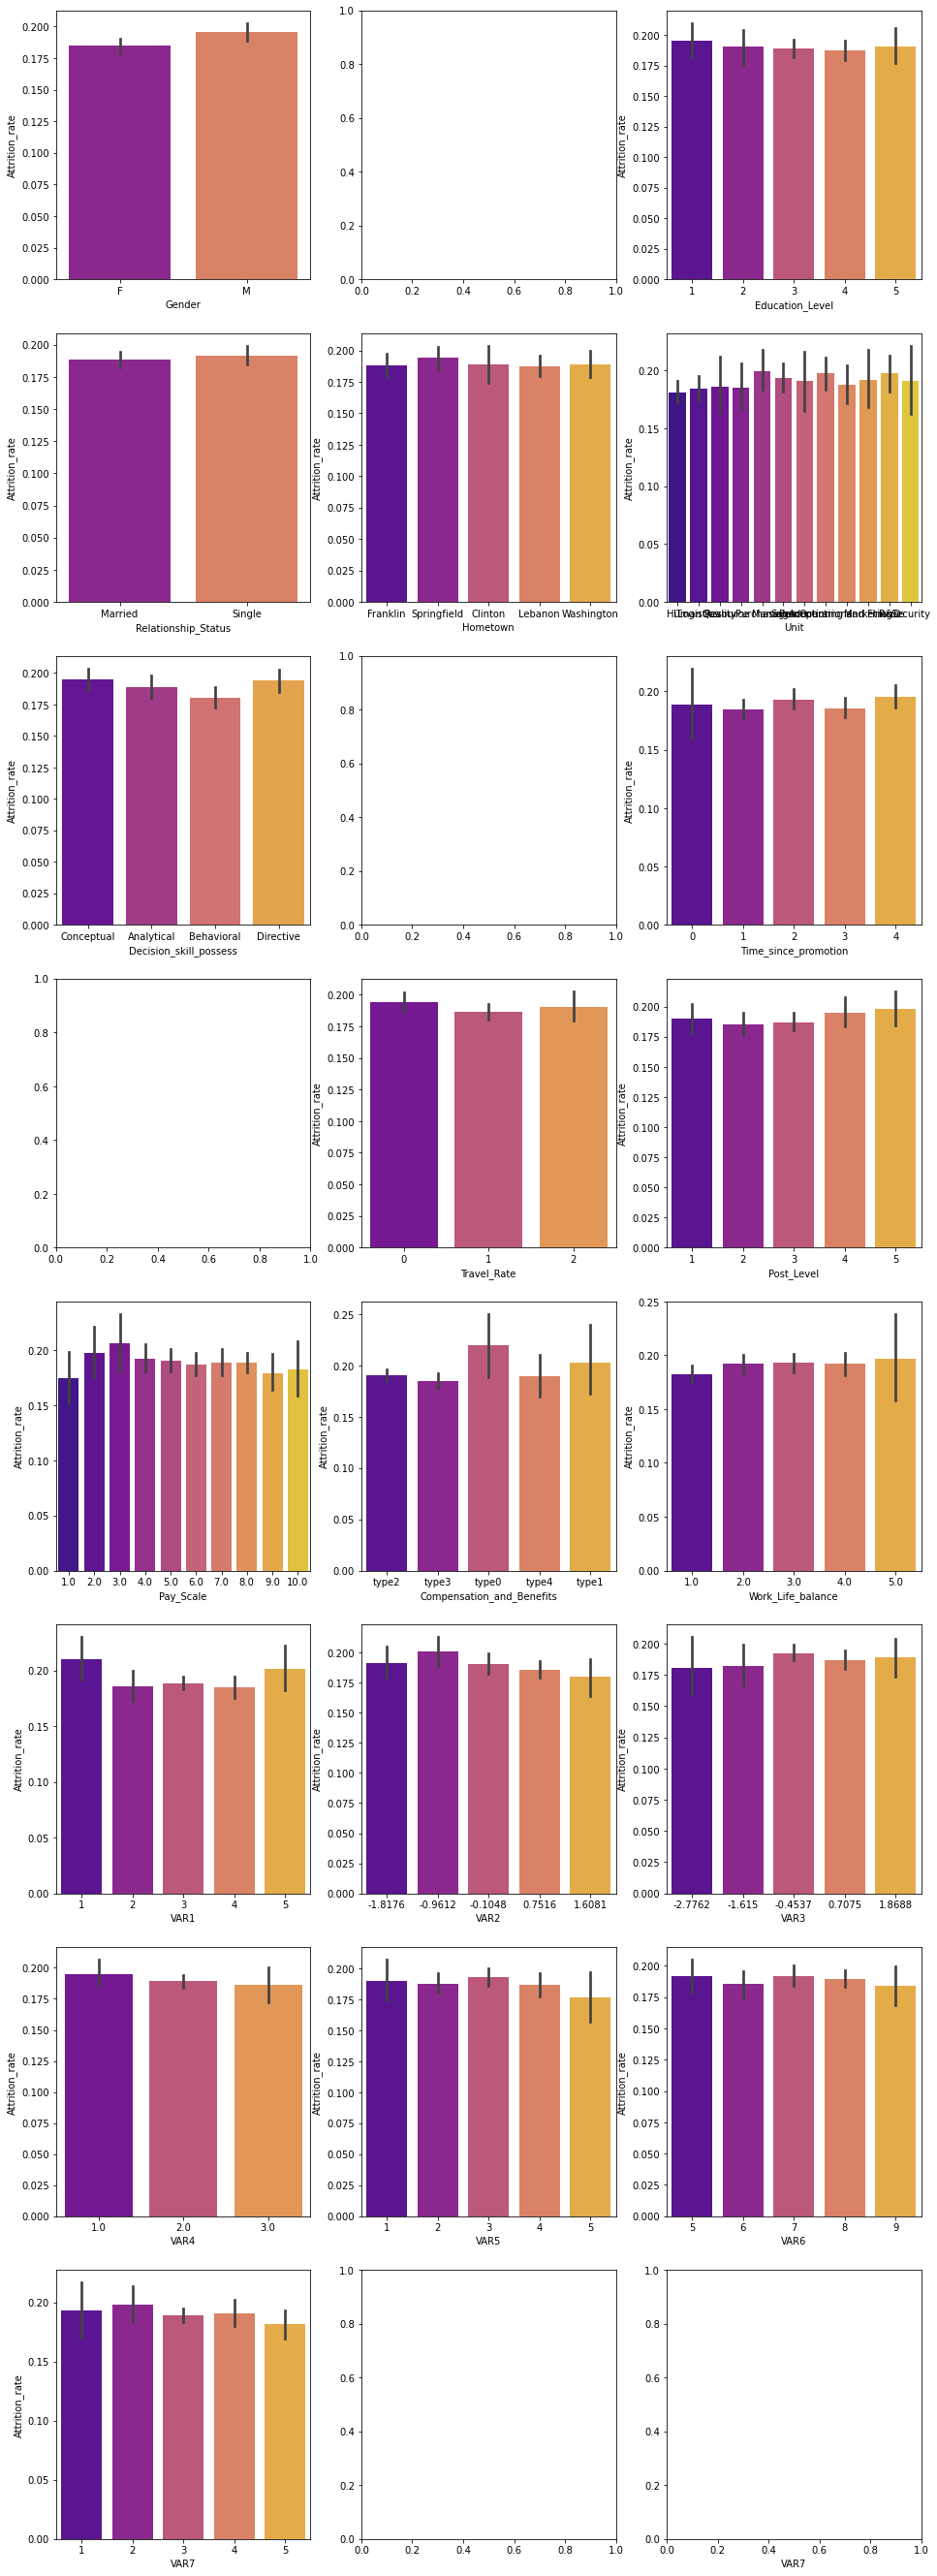

In [41]:
bivar_plot_reg_all_dim_snsbar()

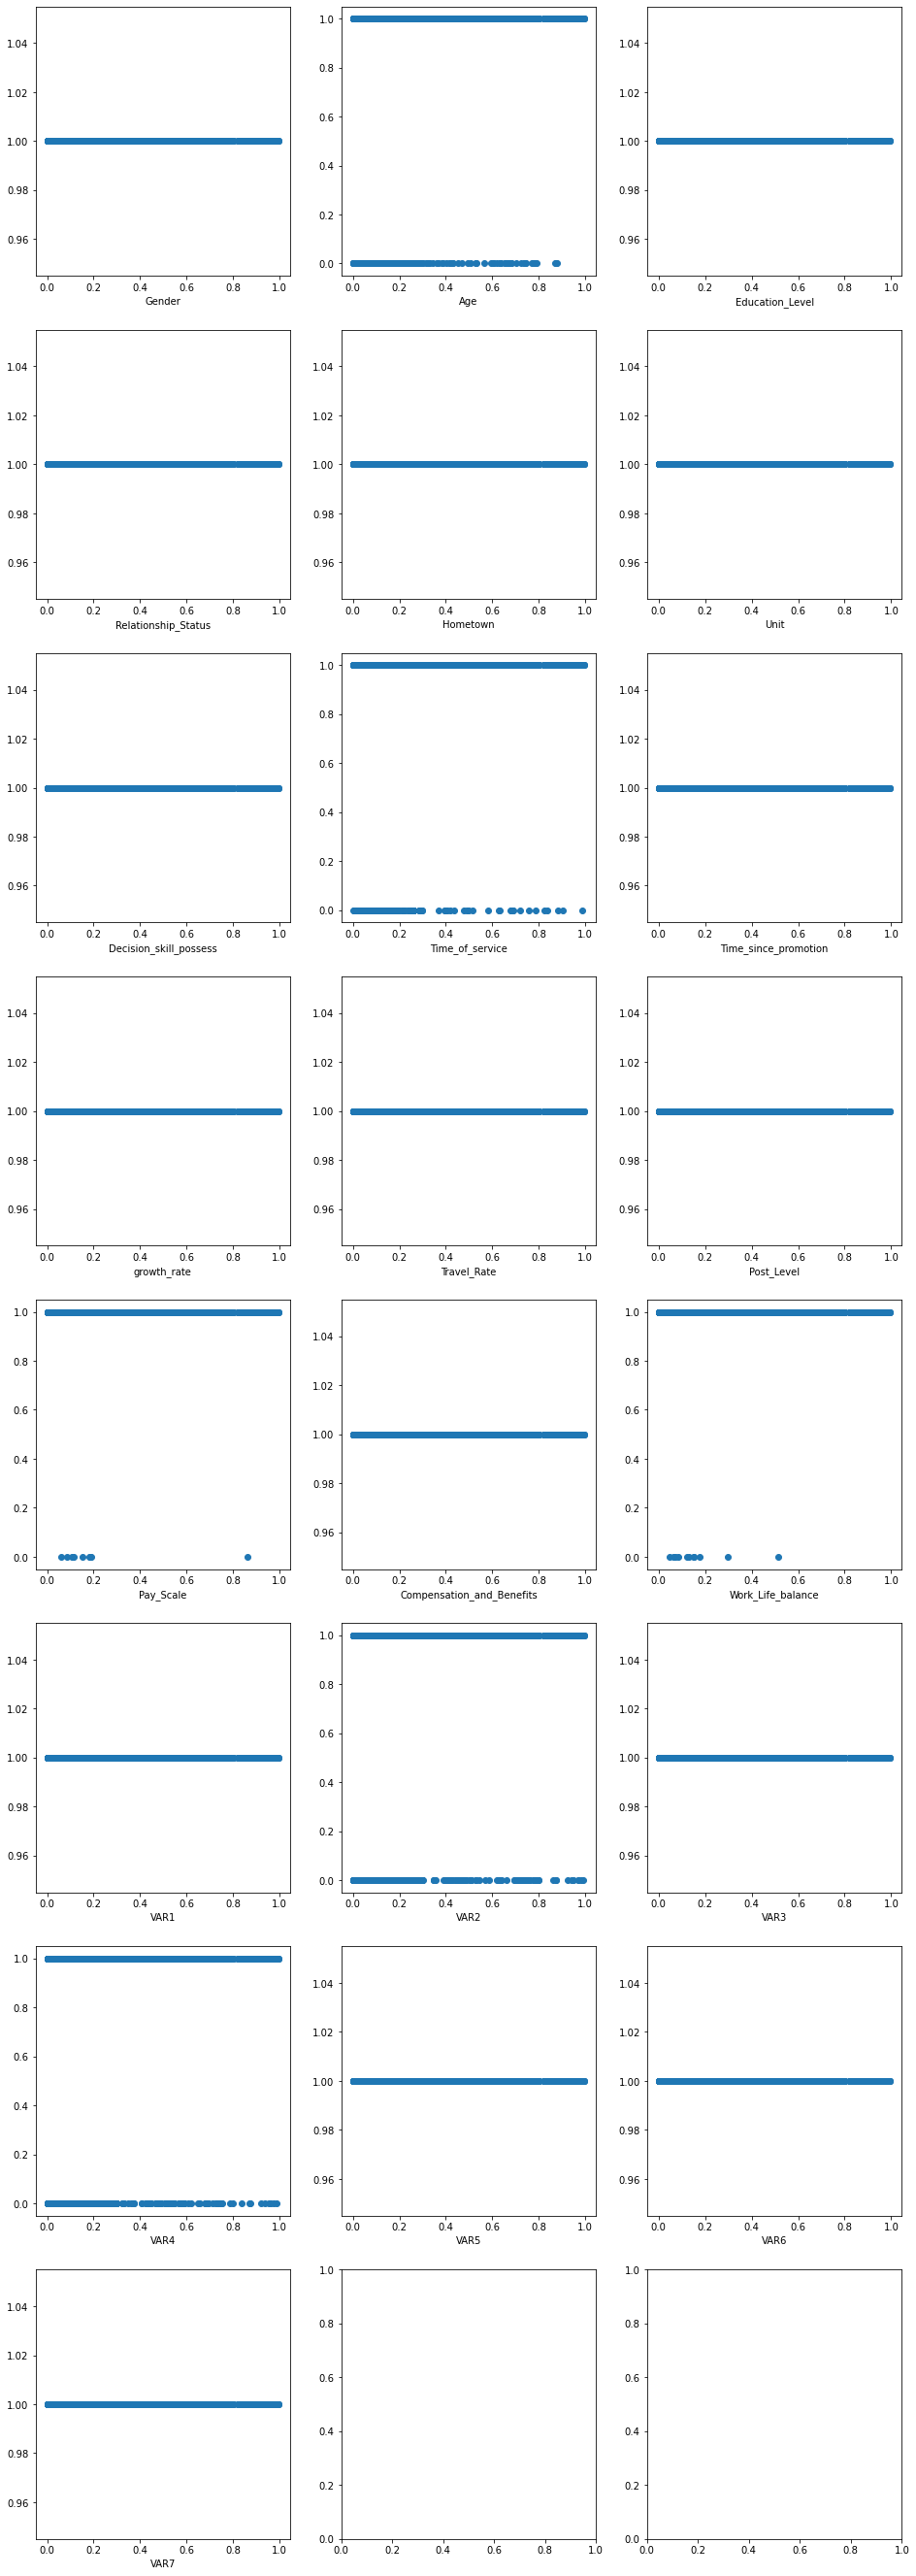

In [44]:
bivar_plot_reg_all_dim()

In [46]:
data['Attrition_rate'].value_counts()

0.1042    10
0.1294     9
0.0312     9
0.1506     8
0.0015     8
          ..
0.4958     1
0.0699     1
0.3687     1
0.2768     1
0.2583     1
Name: Attrition_rate, Length: 3317, dtype: int64

In [48]:
data.head(2)

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,source
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841,train
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670,train


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                10000 non-null  object 
 1   Gender                     10000 non-null  object 
 2   Age                        9427 non-null   float64
 3   Education_Level            10000 non-null  int64  
 4   Relationship_Status        10000 non-null  object 
 5   Hometown                   10000 non-null  object 
 6   Unit                       10000 non-null  object 
 7   Decision_skill_possess     10000 non-null  object 
 8   Time_of_service            9804 non-null   float64
 9   Time_since_promotion       10000 non-null  int64  
 10  growth_rate                10000 non-null  int64  
 11  Travel_Rate                10000 non-null  int64  
 12  Post_Level                 10000 non-null  int64  
 13  Pay_Scale                  9988 non-null   floa

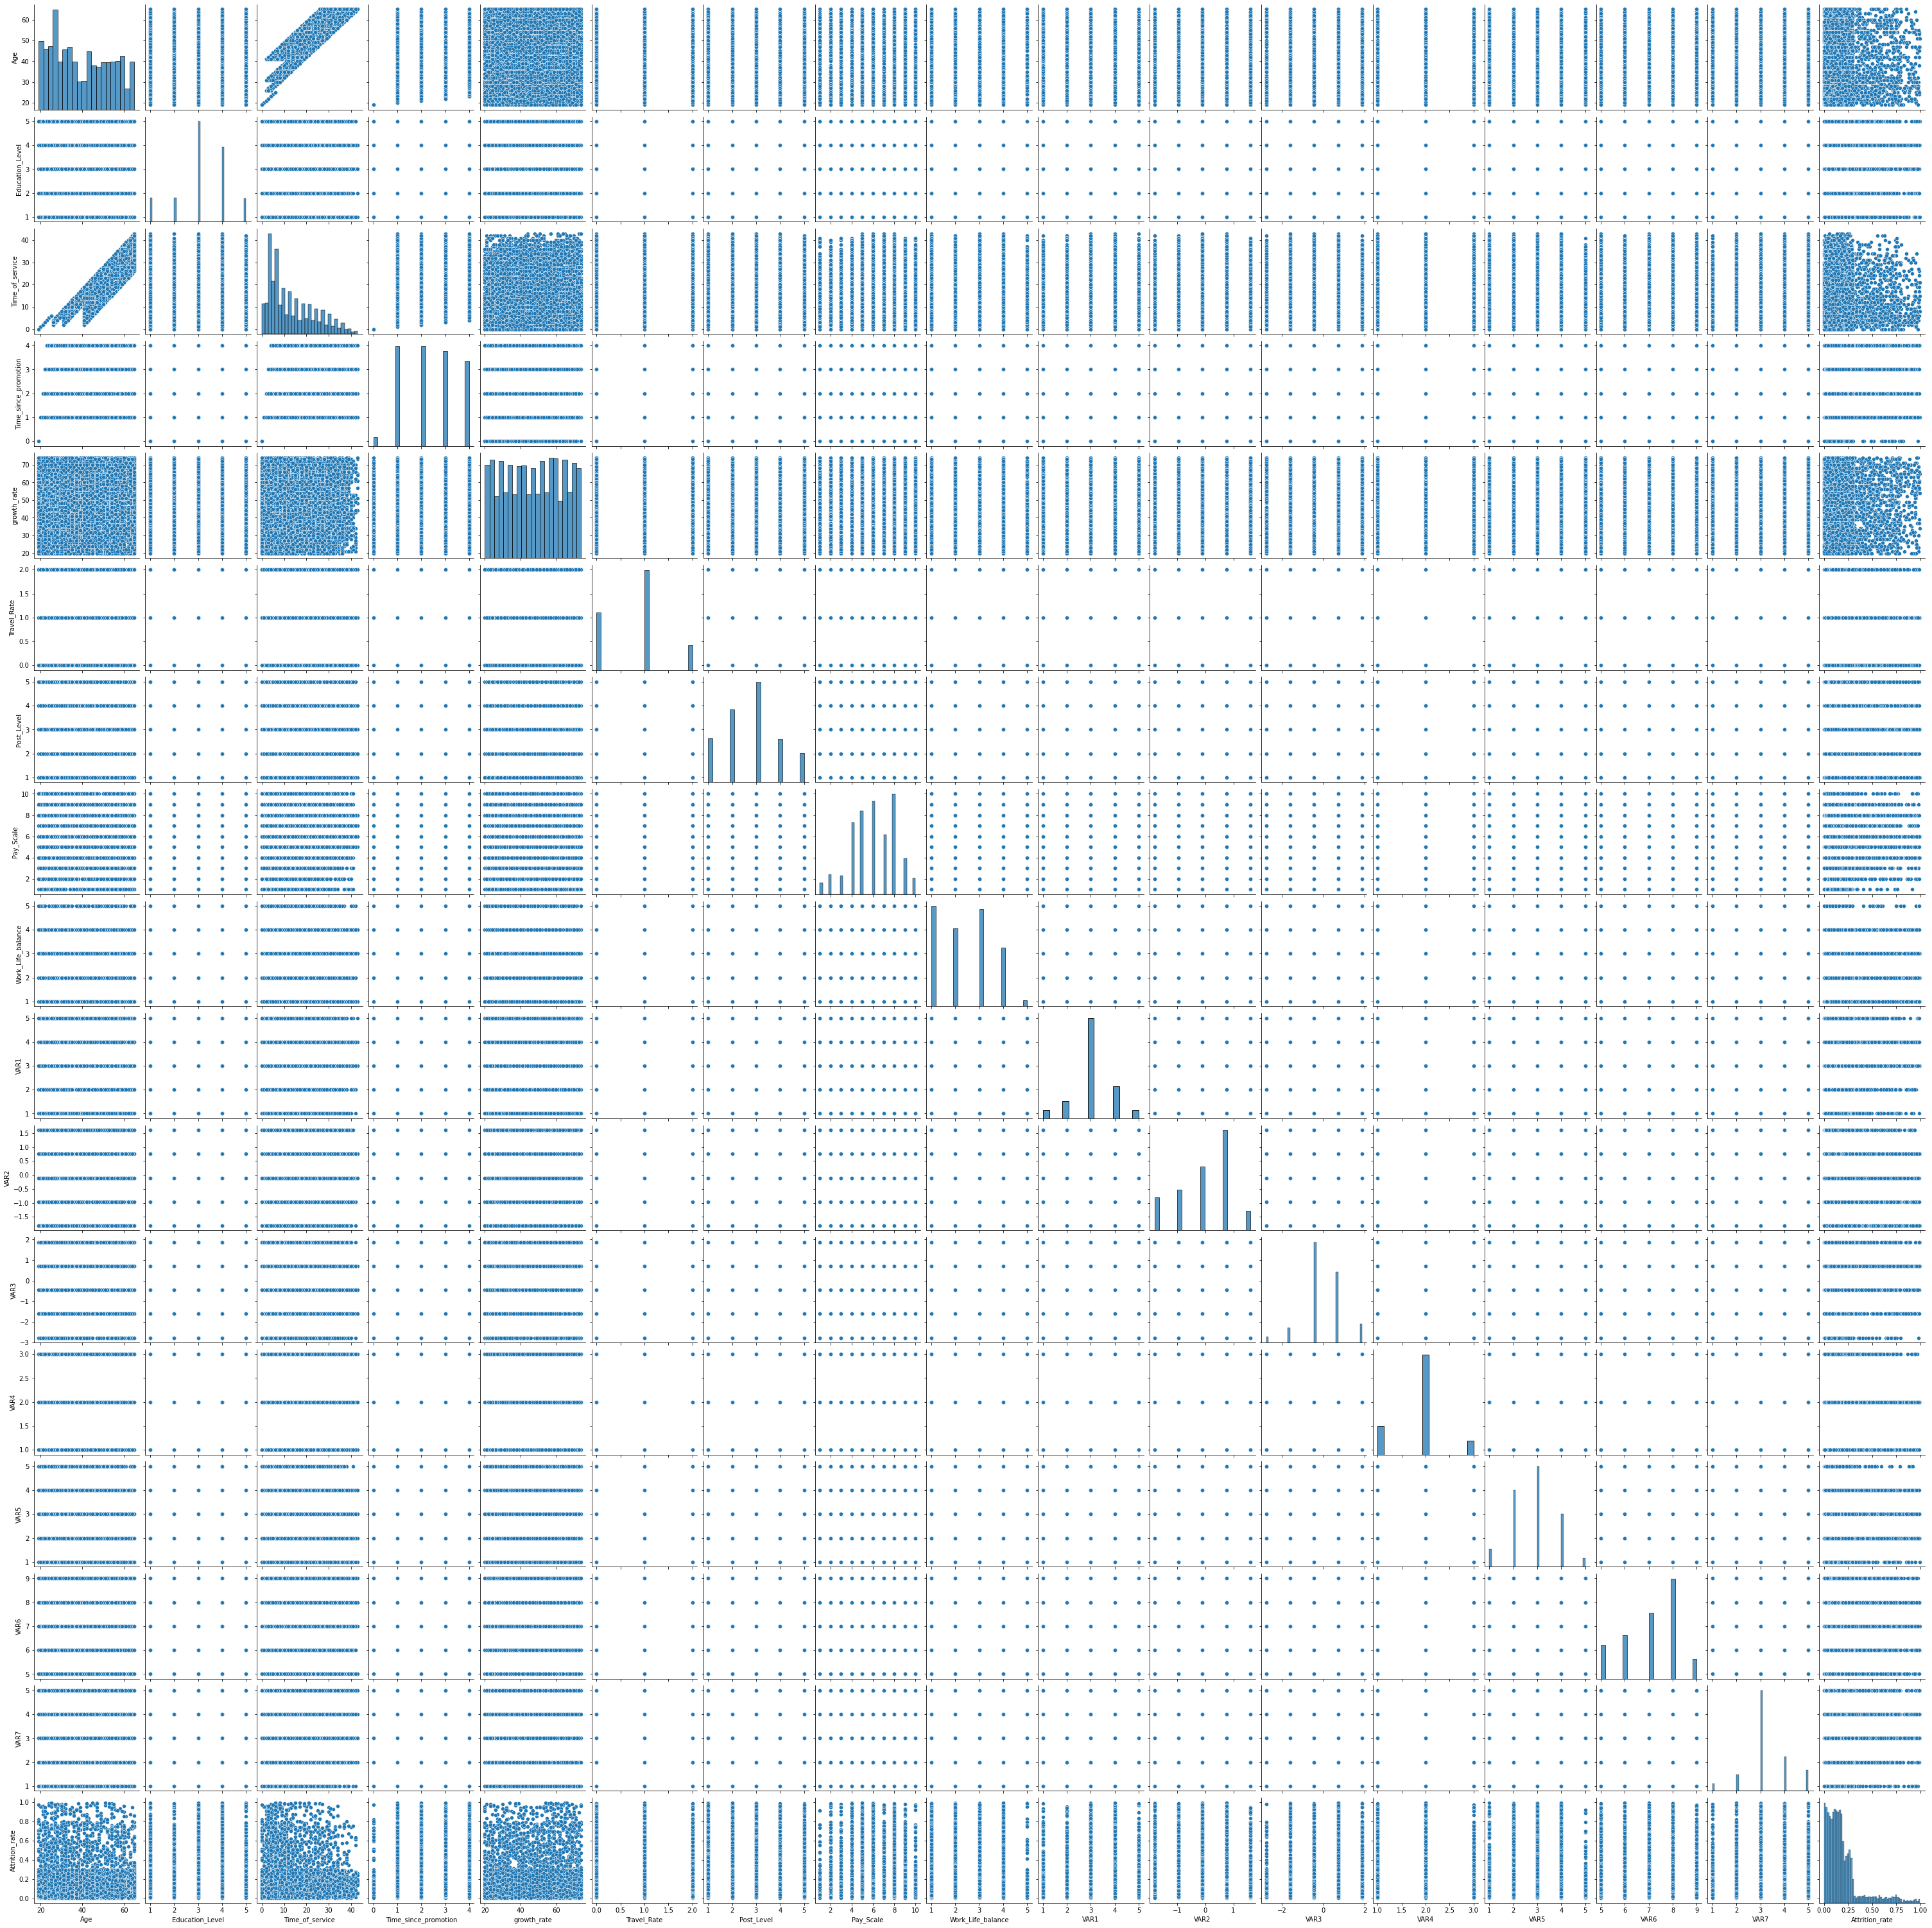

In [265]:
sns_plot = sns.pairplot(data)
sns_plot.savefig('pairplot.png')

In [52]:
display(range_calc(data,['Gender','Age','Relationship_Status'],['Attrition_rate']))

value_count     min     max  count
Gender Age  Relationship_Status                                    
F      19.0 Married                       75  0.0010  0.8190     49
            Single                        58  0.0074  0.7798     43
       20.0 Married                       71  0.0002  0.7640     50
            Single                        40  0.0064  0.5502     28
       21.0 Married                       92  0.0191  0.9572     64
...                                      ...     ...     ...    ...
M      63.0 Single                        19  0.0198  0.3738     11
       64.0 Married                       39  0.0070  0.7543     35
            Single                        16  0.0013  0.9447     12
       65.0 Married                       50  0.0081  0.6305     38
            Single                        36  0.0038  0.7915     29

[188 rows x 4 columns]

#### Data Preprocessing

In [53]:
null_percent(data)

for all features
573 ( 5.73 %)--> Age
196 ( 1.96 %)--> Time_of_service
12 ( 0.12 %)--> Pay_Scale
16 ( 0.16 %)--> Work_Life_balance
794 ( 7.94 %)--> VAR2
954 ( 9.54 %)--> VAR4
3000 ( 30.0 %)--> Attrition_rate


In [56]:
combinfo(data)

,Nunique(),isna() count,Non-Null count,Dtype
Column,,,,
Employee_ID,10000,0,10000,object
Gender,2,0,10000,object
Age,47,573,9427,float64
Education_Level,5,0,10000,int64
Relationship_Status,2,0,10000,object
Hometown,5,0,10000,object
Unit,12,0,10000,object
Decision_skill_possess,4,0,10000,object
Time_of_service,44,196,9804,float64


In [254]:
def data_preprc():
    data = pd.concat([train,test])
    data_orig = data.copy()
    #display(data.head(2))
    data = data.reset_index().drop(columns="index")

    data['Attrition_rate'] = np.where(data['Attrition_rate'] >0.5, 1,0)
    
    data['Age'] = data['Age'].fillna(0)
    data['Time_of_service'] = data['Time_of_service'].fillna(0)
    data['Pay_Scale'] = data['Pay_Scale'].fillna(0)
    data['Work_Life_balance'] = data['Work_Life_balance'].fillna(0)
    data['VAR2'] = data['VAR2'].fillna(0)
    data['VAR4'] = data['VAR4'].fillna(0)
    
    data["Gender"] = np.where(data["Gender"]=="M",1,0)
    data["Relationship_Status"] = np.where(data["Relationship_Status"]=="Married",1,0)   
    #data['Hometown'] = data['Hometown'].replace({'Franklin':1 ,'Springfield':2, 'Clinton':3, 'Lebanon':4, 'Washington':5})
    
    numeric_data_columns = data.select_dtypes(include = np.number).drop(columns = [tgt_var]).columns
    display(numeric_data_columns)
    display(data[numeric_data_columns].head(2))    
    
    category_data_columns = data.select_dtypes(exclude = np.number).drop(columns=['Employee_ID',"source"]).columns
    display(category_data_columns)
    display(data[category_data_columns].head(2))
    
    preprocess_cat_data_columns = pd.get_dummies(data[category_data_columns])
    display(preprocess_cat_data_columns.head())
    
    scaler = MinMaxScaler()
    preprocess_numeric_data_columns = pd.DataFrame(scaler.fit_transform(data[numeric_data_columns]), columns=numeric_data_columns)
    display(preprocess_numeric_data_columns.head(2))
    
    print(preprocess_cat_data_columns.shape, preprocess_numeric_data_columns.shape, data.shape)
    print(preprocess_cat_data_columns.index, preprocess_numeric_data_columns.index, data.index)
    
    final_preprocessed = pd.concat([preprocess_cat_data_columns, preprocess_numeric_data_columns, data[["Employee_ID", "Attrition_rate", "source"]]], axis = 1)
    #final_preprocessed = final_preprocessed.drop(final_preprocessed[(final_preprocessed.isna())].index)
    final_preprocessed = final_preprocessed.dropna(how='all',axis=0)
    print(final_preprocessed.shape, final_preprocessed.index)
    display(final_preprocessed.head(2))

    global train_preprocessed 
    global test_preprocessed    
    train_preprocessed = final_preprocessed[final_preprocessed["source"]=="train"]
    test_preprocessed = final_preprocessed[final_preprocessed["source"]=="test"]
    train_preprocessed = train_preprocessed.drop(columns = ["source"])
    test_preprocessed = test_preprocessed.drop(columns = ["source"])
    train_preprocessed = train_preprocessed.reset_index().drop(columns='index')
    test_preprocessed = test_preprocessed.reset_index().drop(columns='index')
    print(train_preprocessed.shape, test_preprocessed.shape)
    print(train_preprocessed.index, test_preprocessed.index)
    
    # Class count
    print('Before Random sampling:')
    print(train_preprocessed['Attrition_rate'].value_counts())
    count_class_0, count_class_1 = train_preprocessed['Attrition_rate'].value_counts().sort_index()
    # Divide by class
    df_class_0 = train_preprocessed[train_preprocessed['Attrition_rate'] == 0]
    df_class_1 = train_preprocessed[train_preprocessed['Attrition_rate'] == 1]
        
    #Random undersampling
    df_class_0_und = df_class_0.sample(count_class_1, replace=True)
    train_preprocessed_sampling = pd.concat([df_class_1, df_class_0_und], axis=0)
        
    print('After Random sampling:')
    print(train_preprocessed_sampling.Attrition_rate.value_counts()) 
    train_preprocessed = train_preprocessed_sampling.copy()
    
    print('preprc over')

In [57]:
data.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,source
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841,train
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670,train
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851,train
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668,train
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827,train


In [173]:
data.Unit.unique()

array(['IT', 'Logistics', 'Quality', 'Human Resource Management',
       'Purchasing', 'Sales', 'Production', 'Operarions',
       'Accounting and Finance', 'Marketing', 'R&D', 'Security'],
      dtype=object)

### Modelling

In [54]:
tracking_uri = mlflow.get_tracking_uri()
print(tracking_uri)
mlflow.set_tracking_uri("file:///D:/Zia/Datas/inceptez/mltracking/mlflow/notebooks/mlruns")
tracking_uri = mlflow.get_tracking_uri()
print(tracking_uri)

file:///D:/Zia/Datas/inceptez/hackathon-i2/he_PredEmpAttrRate_clf/mlruns
file:///D:/Zia/Datas/inceptez/mltracking/mlflow/notebooks/mlruns


In [256]:
logging = False
displaying = True
alpha_range = [1000, 100, 10, 1, .1, .01, .001, .0001]#[1,0.1] #[10, 1, .1, .01] #
model_keyval = []
n_alpha = 0
model_num = 0
l1_ratio = 0
n_knn = 0

train_preprocessed = pd.DataFrame() 
test_preprocessed = pd.DataFrame()
data_preprc()

X = train_preprocessed.drop(columns=["Employee_ID","Attrition_rate"])
y = train_preprocessed[["Attrition_rate"]]
display(X.head(2),y.head(2))
null_percent(X)
null_percent(y)

model = LogisticRegression(penalty='none', class_weight='balanced') #test1,
#model = LogisticRegression(penalty='l2', class_weight='balanced') test2
#model = KNeighborsClassifier(n_neighbors=3) #test3
#y_train_pred = 
build_model(model,X,y, "Train", "classification", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
test_X = test_preprocessed.drop(columns=["Employee_ID","Attrition_rate"])
y_test_pred = model.predict_proba(test_X)[:,1]

submission = pd.DataFrame()
submission["Employee_ID"] = test_preprocessed["Employee_ID"]
submission["Attrition_rate"] = y_test_pred
#submission["price"] = np.round(np.expm1(y_test_pred),2)

print(submission[submission['Attrition_rate']<0].head())
submission["Attrition_rate"] = abs(y_test_pred)
print(submission[submission['Attrition_rate']<0].head())
print(submission.index)
#print(submission)
print(submission["Attrition_rate"].max())
#submission.to_csv("test1_fill0_logreg_result1.csv", index = False)
#sub:15.71706
#submission.to_csv("test2_fill0_logreg0_15_result2.csv", index = False)
#sub: 12.71960
#submission.to_csv("test1_fill0_logreg0_5_result3.csv", index = False)
#n/s
#submission.to_csv("test3_fill0_logreg0_5_result1.csv", index = False)
#sub: 14.68890
#submission.to_csv("test4_fill0_logreg0_5_und_result1.csv", index = False)
#sub: 12.56680

Index(['Gender', 'Age', 'Education_Level', 'Relationship_Status',
       'Time_of_service', 'Time_since_promotion', 'growth_rate', 'Travel_Rate',
       'Post_Level', 'Pay_Scale', 'Work_Life_balance', 'VAR1', 'VAR2', 'VAR3',
       'VAR4', 'VAR5', 'VAR6', 'VAR7'],
      dtype='object')

,Gender,Age,Education_Level,Relationship_Status,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,0,42.0,4,1,4.0,4,33,1,1,7.0,3.0,4,0.7516,1.8688,2.0,4,5,3
1,1,24.0,3,0,5.0,4,36,0,3,6.0,4.0,3,-0.9612,-0.4537,2.0,3,5,3


Index(['Hometown', 'Unit', 'Decision_skill_possess',
       'Compensation_and_Benefits'],
      dtype='object')

,Hometown,Unit,Decision_skill_possess,Compensation_and_Benefits
0,Franklin,IT,Conceptual,type2
1,Springfield,Logistics,Analytical,type2


,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,...,Unit_Security,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


,Gender,Age,Education_Level,Relationship_Status,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,0.0,0.646154,0.75,1.0,0.093023,1.0,0.240741,0.5,0.0,0.7,0.6,0.75,0.749978,1.0,0.666667,0.75,0.0,0.5
1,1.0,0.369231,0.50,0.0,0.116279,1.0,0.296296,0.0,0.5,0.6,0.8,0.50,0.249993,0.5,0.666667,0.50,0.0,0.5


(10000, 26) (10000, 18) (10000, 25)
RangeIndex(start=0, stop=10000, step=1) RangeIndex(start=0, stop=10000, step=1) RangeIndex(start=0, stop=10000, step=1)
(10000, 47) Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=10000)


,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,...,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Employee_ID,Attrition_rate,source
0,0,1,0,0,0,0,0,1,0,0,...,0.75,0.749978,1.0,0.666667,0.75,0.0,0.5,EID_23371,0,train
1,0,0,0,1,0,0,0,0,1,0,...,0.50,0.249993,0.5,0.666667,0.50,0.0,0.5,EID_18000,0,train


(7000, 46) (3000, 46)
RangeIndex(start=0, stop=7000, step=1) RangeIndex(start=0, stop=3000, step=1)
Before Random sampling:
0    6426
1     574
Name: Attrition_rate, dtype: int64
After Random sampling:
1    574
0    574
Name: Attrition_rate, dtype: int64
preprc over


,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,...,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
5,0,0,1,0,0,0,0,0,0,0,...,1.00,0.9,0.2,0.5,0.000000,1.000000,0.666667,0.25,0.75,0.50
19,0,0,1,0,0,0,0,1,0,0,...,0.75,0.5,0.2,0.5,0.530578,0.749989,0.333333,0.00,0.00,0.75


,Attrition_rate
5,1
19,1


for all features
for all features
buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
6665               0
5746               0
3503               0
6645               0
1601               0

[1148 rows x 1 columns]
bm-ytp [1 0 1 ... 0 0 0]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 0 1 ... 0 0 0]
Model : LogisticRegression(class_weight='balanced', penalty='none')
Train Accuracy  score : 0.5905923344947736
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5931899641577061
Train F1        score : 0.5848056537102474
Train ROC_AUC   score : 0.5905923344947736
Train Confusion Matrix:
 [[347 227]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.6

<class 'pandas.core.frame.DataFrame'>       0
0     0
1     0
2     0
3     0
4     0
...  ..
6995  1
6996  0
6997  1
6998  0
6999  0

[7000 rows x 1 columns]
0    6426
1     574
dtype: int64


<AxesSubplot:xlabel='Attrition_rate', ylabel='Density'>

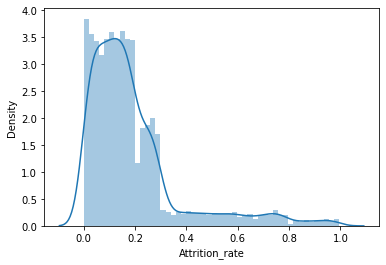

In [190]:
z=pd.DataFrame(np.where(train['Attrition_rate'] >0.5, 1,0))
print(type(z),z)
print(z.value_counts())
#sns.distplot(z)
#sns.show()
sns.distplot(train['Attrition_rate'])

In [257]:
mlflow.end_run()
logging = False
displaying = True
res=[]

train_preprocessed = pd.DataFrame() 
test_preprocessed = pd.DataFrame()
data_preprc()

X = train_preprocessed.drop(columns=["Employee_ID","Attrition_rate"])
y = train_preprocessed[["Attrition_rate"]]
#display(X.head(2),y.head(2))

alpha_range = [1000, 100, 10, 1, .1, .01, .001, .0001]#[1,0.1] #[10, 1, .1, .01] #
model_keyval = []
n_alpha = 0
model_num = 0
l1_ratio = 0
n_knn = 0

all_models = ["LogisticRegression", "RidgeClassifier",    "LassoClassifier","ElasticNetClassifier","KNeighborsClassifier"]
for i_model in tqdm(all_models) :
    model_num = all_models.index(i_model)+1
    model_keyval.append(all_models.index(i_model)+1)
    if i_model == "LogisticRegression" : 
        model = LogisticRegression(penalty='none', class_weight='balanced')
        display('logreg',X,y)
        build_model(model,X,y, "Train", "classification", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "RidgeClassifier" :
        for n_alpha in tqdm(alpha_range) :
            model = RidgeClassifier(alpha = n_alpha)
            build_model(model,X,y, "Train", "classification", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "LassoClassifier" :
        for n_alpha in tqdm(alpha_range) :
            #model = Lasso(alpha = n_alpha)
            model = LogisticRegression(penalty='l1', class_weight='balanced', solver='saga')#, alpha=n_alpha)
            build_model(model,X,y, "Train", "classification", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
    if i_model == "ElasticNetClassifier" :
        for n_alpha in tqdm(alpha_range) :
            for l1_ratio in np.arange(0.0, 1.1, 0.1) : 
                #model = ElasticNet(alpha = n_alpha, l1_ratio = l1_ratio)
                model = LogisticRegression(penalty='elasticnet', class_weight='balanced', solver='saga',l1_ratio=l1_ratio)# alpha=n_alpha, 
                build_model(model,X,y, "Train", "classification", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)    
    if i_model == "KNeighborsClassifier" :
        for n_knn in tqdm(range(1,11)) :
            model = KNeighborsClassifier(n_neighbors = n_knn)
            build_model(model,X,y, "Train", "classification", displaying, logging, model_num, n_alpha, l1_ratio, n_knn)
pd.DataFrame(res).to_csv("result.csv",index=False)
            

Index(['Gender', 'Age', 'Education_Level', 'Relationship_Status',
       'Time_of_service', 'Time_since_promotion', 'growth_rate', 'Travel_Rate',
       'Post_Level', 'Pay_Scale', 'Work_Life_balance', 'VAR1', 'VAR2', 'VAR3',
       'VAR4', 'VAR5', 'VAR6', 'VAR7'],
      dtype='object')

,Gender,Age,Education_Level,Relationship_Status,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,0,42.0,4,1,4.0,4,33,1,1,7.0,3.0,4,0.7516,1.8688,2.0,4,5,3
1,1,24.0,3,0,5.0,4,36,0,3,6.0,4.0,3,-0.9612,-0.4537,2.0,3,5,3


Index(['Hometown', 'Unit', 'Decision_skill_possess',
       'Compensation_and_Benefits'],
      dtype='object')

,Hometown,Unit,Decision_skill_possess,Compensation_and_Benefits
0,Franklin,IT,Conceptual,type2
1,Springfield,Logistics,Analytical,type2


,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,...,Unit_Security,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


,Gender,Age,Education_Level,Relationship_Status,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
0,0.0,0.646154,0.75,1.0,0.093023,1.0,0.240741,0.5,0.0,0.7,0.6,0.75,0.749978,1.0,0.666667,0.75,0.0,0.5
1,1.0,0.369231,0.50,0.0,0.116279,1.0,0.296296,0.0,0.5,0.6,0.8,0.50,0.249993,0.5,0.666667,0.50,0.0,0.5


(10000, 26) (10000, 18) (10000, 25)
RangeIndex(start=0, stop=10000, step=1) RangeIndex(start=0, stop=10000, step=1) RangeIndex(start=0, stop=10000, step=1)
(10000, 47) Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=10000)


,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,...,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Employee_ID,Attrition_rate,source
0,0,1,0,0,0,0,0,1,0,0,...,0.75,0.749978,1.0,0.666667,0.75,0.0,0.5,EID_23371,0,train
1,0,0,0,1,0,0,0,0,1,0,...,0.50,0.249993,0.5,0.666667,0.50,0.0,0.5,EID_18000,0,train


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

(7000, 46) (3000, 46)
RangeIndex(start=0, stop=7000, step=1) RangeIndex(start=0, stop=3000, step=1)
Before Random sampling:
0    6426
1     574
Name: Attrition_rate, dtype: int64
After Random sampling:
1    574
0    574
Name: Attrition_rate, dtype: int64
preprc over


'logreg'

,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,...,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
5,0,0,1,0,0,0,0,0,0,0,...,1.00,0.9,0.2,0.50,0.000000,1.000000,0.666667,0.25,0.75,0.50
19,0,0,1,0,0,0,0,1,0,0,...,0.75,0.5,0.2,0.50,0.530578,0.749989,0.333333,0.00,0.00,0.75
25,0,0,0,0,1,0,0,0,0,1,...,0.50,0.3,0.2,0.50,0.499985,0.500000,0.333333,0.75,0.75,0.25
27,0,0,1,0,0,0,0,0,0,0,...,0.75,0.8,0.2,0.50,0.749978,0.749989,0.666667,0.50,0.75,0.50
38,0,0,1,0,0,0,0,0,1,0,...,0.00,1.0,0.4,0.25,0.749978,0.500000,0.000000,0.25,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,0,1,0,0,0,1,0,0,0,0,...,0.50,0.5,0.6,0.25,0.530578,0.749989,0.666667,0.50,0.00,0.50
2207,0,0,1,0,0,0,0,0,1,0,...,1.00,0.8,0.2,0.75,0.249993,0.500000,0.666667,0.25,0.75,0.25
6133,0,0,0,1,0,0,0,0,1,0,...,0.75,0.5,0.8,0.75,0.749978,0.749989,0.333333,0.75,0.75,0.50
114,0,0,0,1,0,0,0,0,0,0,...,0.75,0.5,0.6,0.50,0.530578,1.000000,0.666667,0.50,0.75,0.50


,Attrition_rate
5,1
19,1
25,1
27,1
38,1
...,...
3523,0
2207,0
6133,0
114,0


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  8.27it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [0 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='none')
Train Accuracy  score : 0.5940766550522648
Train Recall    score : 0.573170731707317
Train Precision score : 0.5981818181818181
Train F1        score : 0.5854092526690391
Train ROC_AUC   score : 0.5940766550522647
Train Confusion Matrix:
 [[353 221]
 [245 329]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.61      0.60       574
           1       0.60


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 0 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 0 1]
Model : RidgeClassifier(alpha=1000)
Train Accuracy  score : 0.5574912891986062
Train Recall    score : 0.5609756097560976
Train Precision score : 0.5570934256055363
Train F1        score : 0.5590277777777778
Train ROC_AUC   score : 0.5574912891986064
Train Confusion Matrix:
 [[318 256]
 [252 322]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.56      0.55      0.56       574
           1       0.56      0.56      0.56       574



 25%|█████████████████████                                                               | 2/8 [00:00<00:00, 11.73it/s]

0.5722996515679443
Train Recall    score : 0.5592334494773519
Train Precision score : 0.5742397137745975
Train F1        score : 0.5666372462488968
Train ROC_AUC   score : 0.5722996515679443
Train Confusion Matrix:
 [[336 238]
 [253 321]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.57      0.59      0.58       574
           1       0.57      0.56      0.57       574

    accuracy                           0.57      1148
   macro avg       0.57      0.57      0.57      1148
weighted avg       0.57      0.57      0.57      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0      

[5 rows x 44 columns]     Attrition_rate
5                1
19               1
25               1
27               1
38               1
<class 'pandas.core.frame.DataFrame'>     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                        


 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00, 12.09it/s]


     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                   0                  0                 1   
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                       0                    0                            0   
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
5                                 0        0               0           


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:00<00:00, 12.29it/s]

       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [0 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 1 0 ... 1 1 1]
Model : RidgeClassifier(alpha=0.01)
Train Accuracy  score : 0.5940766550522648
Train Recall    score : 0.573170731707317
Train Precision score : 0.5981818181818181
Train F1        score : 0.5854092526690391
Train ROC_AUC   score : 0.5940766550522647
Train Confusion Matrix:
 [[353 221]
 [245 329]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.61      0.60       574
           1       0.60      0.57      0.59       574

    accuracy

Model : RidgeClassifier(alpha=0.0001)
Train Accuracy  score : 0.5940766550522648
Train Recall    score : 0.573170731707317
Train Precision score : 0.5981818181818181
Train F1        score : 0.5854092526690391
Train ROC_AUC   score : 0.5940766550522647
Train Confusion Matrix:
 [[353 221]
 [245 329]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.61      0.60       574
           1       0.60      0.57      0.59       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0      


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                   0                  0                 1   
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                       0                    0                            0   
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
5                                 0        0               0           


 12%|██████████▌                                                                         | 1/8 [00:00<00:00,  9.03it/s]

       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
           1       0.5


 25%|█████████████████████                                                               | 2/8 [00:00<00:00,  9.25it/s]

Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
           1       0.59      0.58      0.59       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25


 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:00,  9.13it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
          


 50%|██████████████████████████████████████████                                          | 4/8 [00:00<00:00,  9.25it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
          


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00,  9.44it/s]

       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
           1       0.5


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:00<00:00,  9.44it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
          


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:00<00:00,  9.26it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
          


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
          

Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.57      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19   

[5 rows x 44 columns]     Attrition_rate
5                1
19               1
25               1
27               1
38               1
<class 'pandas.core.frame.DataFrame'>     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                        

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.4, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5932504440497336
Train F1        score : 0.5875109938434477
Train ROC_AUC   score : 0.5914634146341464
Train Confusion Matrix:
 [[345 229]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

38               1
<class 'pandas.core.frame.DataFrame'>     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                            0   

    Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
5                           

     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   
151                 0                  1                 0   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   
151                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
25                                0        0               0            

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.8, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5801393728222997
Train Precision score : 0.5935828877005348
Train F1        score : 0.586784140969163
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[346 228]
 [241 333]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59

[5 rows x 46 columns]
     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   
151                 0                  1                 0   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   
151                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
25                                0        0      


 12%|██████████▌                                                                         | 1/8 [00:01<00:10,  1.50s/it]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=1.0, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59

[5 rows x 46 columns]
     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                   0                  0                 1   
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                       0                    0                            0   
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
5                                 0        0      

Model : LogisticRegression(class_weight='balanced', l1_ratio=0.2, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5953237410071942
Train F1        score : 0.5858407079646019
Train ROC_AUC   score : 0.5923344947735192
Train Confusion Matrix:
 [[349 225]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.61      0.60       574
           1       0.60      0.58      0.59       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0 

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.4, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5932504440497336
Train F1        score : 0.5875109938434477
Train ROC_AUC   score : 0.5914634146341464
Train Confusion Matrix:
 [[345 229]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

[5 rows x 46 columns]
     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   
151                 0                  1                 0   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   
151                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
25                                0        0      

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.7000000000000001,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5888501742160279
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5910714285714286
Train F1        score : 0.583774250440917
Train ROC_AUC   score : 0.5888501742160279
Train Confusion Matrix:
 [[345 229]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

        

[5 rows x 46 columns]
build_model ovr
buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.9, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-sc


 25%|█████████████████████                                                               | 2/8 [00:03<00:09,  1.52s/it]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=1.0, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [0 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.1, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5942549371633752
Train F1        score : 0.5853227232537578
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[348 226]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.30000000000000004,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5932055749128919
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5953654188948306
Train F1        score : 0.5885462555066079
Train ROC_AUC   score : 0.5932055749128919
Train Confusion Matrix:
 [[347 227]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

      

Model : LogisticRegression(class_weight='balanced', l1_ratio=0.5, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5905923344947736
Train Recall    score : 0.578397212543554
Train Precision score : 0.5928571428571429
Train F1        score : 0.5855379188712523
Train ROC_AUC   score : 0.5905923344947736
Train Confusion Matrix:
 [[346 228]
 [242 332]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
           1       0.59      0.58      0.59       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0  

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.7000000000000001,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5888501742160279
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5910714285714286
Train F1        score : 0.583774250440917
Train ROC_AUC   score : 0.5888501742160279
Train Confusion Matrix:
 [[345 229]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

        


 38%|███████████████████████████████▌                                                    | 3/8 [00:04<00:07,  1.44s/it]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.9, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59

Model : LogisticRegression(class_weight='balanced', l1_ratio=0.0, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.587979094076655
Train Recall    score : 0.5714285714285714
Train Precision score : 0.590990990990991
Train F1        score : 0.5810451727192205
Train ROC_AUC   score : 0.587979094076655
Train Confusion Matrix:
 [[347 227]
 [246 328]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.57      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0    

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.2, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5953237410071942
Train F1        score : 0.5858407079646019
Train ROC_AUC   score : 0.5923344947735192
Train Confusion Matrix:
 [[349 225]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.4, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5932504440497336
Train F1        score : 0.5875109938434477
Train ROC_AUC   score : 0.5914634146341464
Train Confusion Matrix:
 [[345 229]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.58      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19   

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.8, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5801393728222997
Train Precision score : 0.5935828877005348
Train F1        score : 0.586784140969163
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[346 228]
 [241 333]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59


 50%|██████████████████████████████████████████                                          | 4/8 [00:05<00:05,  1.41s/it]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=1.0, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [0 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.1, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5942549371633752
Train F1        score : 0.5853227232537578
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[348 226]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.30000000000000004,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5932055749128919
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5953654188948306
Train F1        score : 0.5885462555066079
Train ROC_AUC   score : 0.5932055749128919
Train Confusion Matrix:
 [[347 227]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

      

Model : LogisticRegression(class_weight='balanced', l1_ratio=0.5, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5905923344947736
Train Recall    score : 0.578397212543554
Train Precision score : 0.5928571428571429
Train F1        score : 0.5855379188712523
Train ROC_AUC   score : 0.5905923344947736
Train Confusion Matrix:
 [[346 228]
 [242 332]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
           1       0.59      0.58      0.59       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0  

Model : LogisticRegression(class_weight='balanced', l1_ratio=0.7000000000000001,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5888501742160279
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5910714285714286
Train F1        score : 0.583774250440917
Train ROC_AUC   score : 0.5888501742160279
Train Confusion Matrix:
 [[345 229]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.58      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19     


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:06<00:04,  1.36s/it]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.9, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [0 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.0, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.587979094076655
Train Recall    score : 0.5714285714285714
Train Precision score : 0.590990990990991
Train F1        score : 0.5810451727192205
Train ROC_AUC   score : 0.587979094076655
Train Confusion Matrix:
 [[347 227]
 [246 328]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59  

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.2, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5953237410071942
Train F1        score : 0.5858407079646019
Train ROC_AUC   score : 0.5923344947735192
Train Confusion Matrix:
 [[349 225]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                            0   

    Unit_Human Resource Management  Unit_IT  Unit_Logistics  Uni

Model : LogisticRegression(class_weight='balanced', l1_ratio=0.6000000000000001,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5888501742160279
Train Recall    score : 0.578397212543554
Train Precision score : 0.5907473309608541
Train F1        score : 0.5845070422535211
Train ROC_AUC   score : 0.5888501742160279
Train Confusion Matrix:
 [[344 230]
 [242 332]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.58      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19     

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.8, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5801393728222997
Train Precision score : 0.5935828877005348
Train F1        score : 0.586784140969163
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[346 228]
 [241 333]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:08<00:02,  1.32s/it]


<class 'pandas.core.frame.DataFrame'>     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                            0   

    Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
5                                0        0   

Train Confusion Matrix:
 [[347 227]
 [246 328]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.57      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0           

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.2, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5953237410071942
Train F1        score : 0.5858407079646019
Train ROC_AUC   score : 0.5923344947735192
Train Confusion Matrix:
 [[349 225]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.4, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5932504440497336
Train F1        score : 0.5875109938434477
Train ROC_AUC   score : 0.5914634146341464
Train Confusion Matrix:
 [[345 229]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.6000000000000001,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5888501742160279
Train Recall    score : 0.578397212543554
Train Precision score : 0.5907473309608541
Train F1        score : 0.5845070422535211
Train ROC_AUC   score : 0.5888501742160279
Train Confusion Matrix:
 [[344 230]
 [242 332]]
Train Classification Report
               precision    recall  f1-score   support

        

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.8, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5801393728222997
Train Precision score : 0.5935828877005348
Train F1        score : 0.586784140969163
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[346 228]
 [241 333]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:09<00:01,  1.31s/it]


     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
25                  0                  0                 0   
38                  0                  0                 1   
135                 0                  0                 0   
146                 0                  0                 1   
151                 0                  1                 0   

     Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
25                      0                    1                            0   
38                      0                    0                            0   
135                     1                    0                            0   
146                     0                    0                            0   
151                     0                    0                            0   

     Unit_Human Resource Management  Unit_IT  Unit_Logistics  Unit_Marketing  \
25                                0        0               0           

[1148 rows x 1 columns]
bm-ytp [0 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.0, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.587979094076655
Train Recall    score : 0.5714285714285714
Train Precision score : 0.590990990990991
Train F1        score : 0.5810451727192205
Train ROC_AUC   score : 0.587979094076655
Train Confusion Matrix:
 [[347 227]
 [246 328]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       574
           1       0.59      0.57      0.58       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<cl

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.2, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5766550522648084
Train Precision score : 0.5953237410071942
Train F1        score : 0.5858407079646019
Train ROC_AUC   score : 0.5923344947735192
Train Confusion Matrix:
 [[349 225]
 [243 331]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.4, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5818815331010453
Train Precision score : 0.5932504440497336
Train F1        score : 0.5875109938434477
Train ROC_AUC   score : 0.5914634146341464
Train Confusion Matrix:
 [[345 229]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.5

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.6000000000000001,
                   penalty='elasticnet', solver='saga')
Train Accuracy  score : 0.5888501742160279
Train Recall    score : 0.578397212543554
Train Precision score : 0.5907473309608541
Train F1        score : 0.5845070422535211
Train ROC_AUC   score : 0.5888501742160279
Train Confusion Matrix:
 [[344 230]
 [242 332]]
Train Classification Report
               precision    recall  f1-score   support

        

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.8, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5914634146341463
Train Recall    score : 0.5801393728222997
Train Precision score : 0.5935828877005348
Train F1        score : 0.586784140969163
Train ROC_AUC   score : 0.5914634146341463
Train Confusion Matrix:
 [[346 228]
 [241 333]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


bm-ytp [1 1 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 0 ... 1 1 1]
Model : LogisticRegression(class_weight='balanced', l1_ratio=0.9, penalty='elasticnet',
                   solver='saga')
Train Accuracy  score : 0.5923344947735192
Train Recall    score : 0.5818815331010453
Train Precision score : 0.594306049822064
Train F1        score : 0.5880281690140844
Train ROC_AUC   score : 0.5923344947735191
Train Confusion Matrix:
 [[346 228]
 [240 334]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       574
           1       0.59      0.58      0.59       574

    accuracy                           0.59      1148
   macro avg       0.59      0.59      0.59      1148
weighted avg       0.59      0.59      0.59      1148

print_score ovr
<class 'pandas.core.fram


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.57it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 1 1 ... 0 0 0]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 1 1 ... 0 0 0]
Model : KNeighborsClassifier(n_neighbors=1)
Train Accuracy  score : 1.0
Train Recall    score : 1.0
Train Precision score : 1.0
Train F1        score : 1.0
Train ROC_AUC   score : 1.0
Train Confusion Matrix:
 [[574   0]
 [  0 574]]
Train Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       574
           1       1.00      1.00      1.00       574

    accuracy                           1.00      1148
   macro avg


 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  5.67it/s]


     Attrition_rate
5                1
19               1
25               1
27               1
38               1
<class 'pandas.core.frame.DataFrame'>     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                            0   

    Unit_Hu

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:01,  5.88it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 0 0 ... 0 0 0]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 0 0 ... 0 0 0]
Model : KNeighborsClassifier(n_neighbors=4)
Train Accuracy  score : 0.6951219512195121
Train Recall    score : 0.5104529616724739
Train Precision score : 0.8093922651933702
Train F1        score : 0.6260683760683761
Train ROC_AUC   score : 0.6951219512195121
Train Confusion Matrix:
 [[505  69]
 [281 293]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.64      0.88      0.74       574
           1       0.81      0.51      0.63   


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  5.91it/s]

     Attrition_rate
5                1
19               1
25               1
27               1
38               1
<class 'pandas.core.frame.DataFrame'>     Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  0                 0   
27                 0                  0                 1   
38                 0                  0                 1   

    Hometown_Springfield  Hometown_Washington  Unit_Accounting and Finance  \
5                      0                    0                            0   
19                     0                    0                            0   
25                     0                    1                            0   
27                     0                    0                            0   
38                     0                    0                            0   

    Unit_Hu


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  5.96it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [1 0 1 ... 0 0 1]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [1 0 1 ... 0 0 1]
Model : KNeighborsClassifier(n_neighbors=7)
Train Accuracy  score : 0.6637630662020906
Train Recall    score : 0.6567944250871081
Train Precision score : 0.666077738515901
Train F1        score : 0.6614035087719298
Train ROC_AUC   score : 0.6637630662020906
Train Confusion Matrix:
 [[385 189]
 [197 377]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.66      0.67      0.67       574
           1       0.67      0.66      0.66    


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  5.80it/s]

buildmodel-y       Attrition_rate
5                  1
19                 1
25                 1
27                 1
38                 1
...              ...
3523               0
2207               0
6133               0
114                0
6478               0

[1148 rows x 1 columns]
bm-ytp [0 0 0 ... 0 0 0]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Attrition_rate
5                1
19               1
25               1
27               1
38               1 [0 0 0 ... 0 0 0]
Model : KNeighborsClassifier(n_neighbors=8)
Train Accuracy  score : 0.6533101045296167
Train Recall    score : 0.5156794425087108
Train Precision score : 0.7115384615384616
Train F1        score : 0.597979797979798
Train ROC_AUC   score : 0.6533101045296167
Train Confusion Matrix:
 [[454 120]
 [278 296]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.62      0.79      0.70       574
           1       0.71      0.52      0.60    


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  5.70it/s]


Model : KNeighborsClassifier(n_neighbors=9)
Train Accuracy  score : 0.6411149825783972
Train Recall    score : 0.6376306620209059
Train Precision score : 0.6421052631578947
Train F1        score : 0.6398601398601398
Train ROC_AUC   score : 0.6411149825783973
Train Confusion Matrix:
 [[370 204]
 [208 366]]
Train Classification Report
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       574
           1       0.64      0.64      0.64       574

    accuracy                           0.64      1148
   macro avg       0.64      0.64      0.64      1148
weighted avg       0.64      0.64      0.64      1148

print_score ovr
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
    Hometown_Clinton  Hometown_Franklin  Hometown_Lebanon  \
5                  0                  0                 1   
19                 0                  0                 1   
25                 0                  

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.81s/it]


In [178]:
res=[]

for i in range(1,10):
    for j in range(11,15):
        res.append((i,j))
pd.DataFrame(res).to_csv("result.csv",index=False)

In [236]:
train2 = train.copy()
train2['y_act'] = np.where(train['Attrition_rate'] >0.5, 1,0)
#train2.to_csv('tr_wthrshld.csv', index=False)
#train_preprocessed['Attrition_rate'] = np.where(train_preprocessed['Attrition_rate'] >0.5, 1,0)


In [ ]:
        # Class count
print('Before Random over-sampling:')
print(train_preprocessed['Attrition_rate'].value_counts())
count_class_0, count_class_1 = train_preprocessed['Attrition_rate'].value_counts().sort_index()
# Divide by class
df_class_0 = train_preprocessed[train_preprocessed['Attrition_rate'] == 0]
df_class_1 = train_preprocessed[train_preprocessed['Attrition_rate'] == 1]
#Random oversampling
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
train_preprocessed_ovr = pd.concat([df_class_1, df_class_0_over], axis=0)
print('After Random over-sampling:')
print(train_preprocessed_ovr.Attrition_rate.value_counts())

<AxesSubplot:>

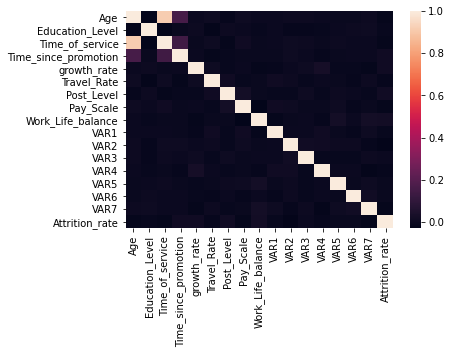

In [259]:
sns.heatmap(data.corr())

<AxesSubplot:>

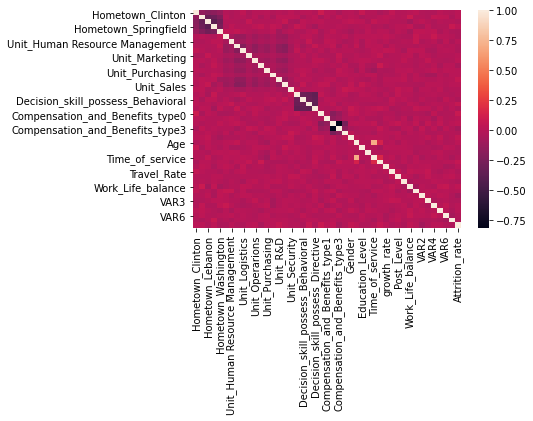

In [258]:
sns.heatmap(train_preprocessed.corr())

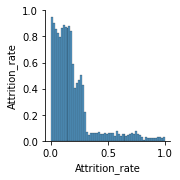

In [267]:
sns_plot = sns.pairplot(data[['Attrition_rate']])
sns_plot.savefig('pairplot_tgt.png')